# ADA: Milestone 3 notebook
---

## Globywood: the story of movie industries across time.

Cinema made its debut in the late 19th century [1] and has become a multibillion-dollar industry, distributed over many different countries, and therefore made subject to distinct cultures and trends.
Using the CMU Movie Summary Corpus, a collection of 42.306 movie plot summaries extracted from Wikipedia, aligned with movie and character metadata, we take a trip through time to take a look at these trends and how they have (or have not) differed across the world.
We will analyze movies from some of the largest film industries - namely the United States, India, United Kingdom, Japan, and France [2] - from the 1950s to the 2010s.
More specifically, we will look from two different perspectives, the movies themselves and the actors that portray them.
This will give us an insight into whether the industry is converging due to globalization, or if each industry can keep its identity.

### Libraries used for this project:

In [1]:
# Local python scripts
import sys
sys.path.append('../src')
import load
import clean
import aggregate
import plot
import features

# Utilities
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: Add libraries here (ONLY if they are used) and put a header (such as NLP) describing what you use it for

## Loading the data

Our analysis will look at differences between film industries from two perspectives, namely the movie themselves and the actors that play in them.
Regarding movies, we will use the `movie.metadata.tsv` dataset for metadata, and `plot_summaries.txt` for the summaries.
Regarding actors we will use the `character.metadata.tsv` dataset.

Our loading functions allows us to do just that:

In [3]:
movies_raw = load.movie_metadata()
summaries_raw = load.plot_summaries()
characters_raw = load.character_metadata()

**Note:** the original movies metadata file uses a dictionary in format `{freebase_id:value}` for the columns `Movie_Countries`, `Movie_Genres`, and `Movie_Languages`. Our loading function parses these values and creates a unique row for each of them, such that each column holds a single value:

In [4]:
movies_raw[['Movie_Name', 'Movie_Countries', 'Movie_Languages', 'Movie_Genres']].head(3)

,Movie_Name,Movie_Countries,Movie_Languages,Movie_Genres
0,Ghosts of Mars,United States of America,English Language,Thriller
0,Ghosts of Mars,United States of America,English Language,Science Fiction
0,Ghosts of Mars,United States of America,English Language,Horror


We now have 3 dataframes to work with for our analysis, the movie metadata, movie summaries, and characters metadata.

## First look at the data

Let's take a look at the number of datapoints we are working with:

In [6]:
ncountries_raw = aggregate.ncountries(movies_raw)
nmovies_raw = aggregate.nmovies(movies_raw)
nsummaries_raw = aggregate.nmovies(summaries_raw)
nactors_raw = aggregate.nactors(characters_raw)
print(f'- Number of countries:  {ncountries_raw:,}')
print(f'- Number of movies:     {nmovies_raw:,}')
print(f'- Number of summaries:  {nsummaries_raw:,}')
print(f'- Number of actors:     {nactors_raw:,}')

- Number of countries:  147
- Number of movies:     81,741
- Number of summaries:  42,303
- Number of actors:     135,760


We already see that some entries have to be dropped from analysis due to missing countries or actors.
More specifically, the following cleaning has to be done before further analysis:
1. Our movie metadata contains movies from 147 countries (and some undefined), we are only interested in a few of them (for this analysis to be feasible).
2. Some characters have undefined actors, and should be dropped from analysis.
3. The character metadata and summaries data should be aligned with the country and date columns from the corresponding movie entries.
4. We have to choose time periods that has enough samples of each of the chosen countries.

### Pre-processing I: countries of interest

To make comparisons between movies of different countries we assume that each movie comes from  a single country.
This is not always the case, we therefore drop all movies that come from multiple countries.

In [7]:
movies_unique = clean.filter_unique_countries(movies_raw)
nmovies_unique = aggregate.nmovies(movies_unique)
print(f'Dropped {nmovies_raw - nmovies_unique:,} movies coming from multiple countries, {nmovies_unique:,} movies remaining.')

Dropped 17,372 movies coming from multiple countries, 64,369 movies remaining.


We are only interested in the largest movie industries of the world according to [1].
To have meaningful comparisons we want to use enough movie samples from each of the country (at least 1000).

In [8]:
aggregate.top_countries_nmovies(movies_unique)

,Wikipedia_Movie_ID
Movie_Countries,
United States of America,30300
India,8240
United Kingdom,5343
Japan,2242
France,1853
Italy,1730
Canada,1342
Argentina,1266
Hong Kong,850


As we see above, we don't have enough movies for all large industries such as China and South Korea, this study will therefore only focus on **US, India, UK, Japan, and France**.

In [9]:
countries_of_interest = ['United States of America', 'India', 'United Kingdom', 'Japan', 'France']
movies_filtered = clean.keep_countries(movies_unique, countries_of_interest)
nmovies_filtered = aggregate.nmovies(movies_filtered)
print(f'Dropped {nmovies_unique - nmovies_filtered:,} movies, {nmovies_filtered:,} movies remaining.')

Dropped 16,391 movies, 47,978 movies remaining.


Now we only keep the characters that come from these countries and add the country as a new column.

In [10]:
characters_filtered = clean.align_movie_countries(characters_raw, movies_filtered)
nactors_filtered = aggregate.nactors(characters_filtered)
print(f'Dropped {nactors_raw - nactors_filtered} actors, {nactors_filtered} actors remaining.')

Dropped 53864 actors, 81896 actors remaining.


As we can see the country of the movie of each character is now added as an extra column.

In [11]:
characters_filtered[['Character_Name', 'Actor_Name', 'Movie_Countries']].head(3)

,Character_Name,Actor_Name,Movie_Countries
0,Akooshay,Wanda De Jesus,United States of America
1,Lieutenant Melanie Ballard,Natasha Henstridge,United States of America
2,Desolation Williams,Ice Cube,United States of America


We do the same for the plot summaries:

In [12]:
summaries_filtered = clean.align_movie_countries(summaries_raw, movies_filtered)
nsummaries_filtered = aggregate.nmovies(summaries_filtered)
print(f'Dropped {nsummaries_raw - nsummaries_filtered} summaries, {nsummaries_filtered} summaries remaining.')
summaries_filtered[['Wikipedia_Movie_ID', 'Movie_Countries', 'Summary']].head(3)

Dropped 15613 summaries, 26690 summaries remaining.


,Wikipedia_Movie_ID,Movie_Countries,Summary
0,975900,United States of America,"Set in the second half of the 22nd century, th..."
1,9363483,United Kingdom,A series of murders of rich young women throug...
2,6631279,United States of America,"Adam, a San Francisco-based artist who works a..."


As seen earlier, some characters have no actor data, and we therefore drop them.

In [13]:
characters_filtered = clean.drop_undefined_actors(characters_filtered)

We completed step 1 to 3 of our cleaning, and see that while keeping 3% of the countries we keep around 60% of our original dataset.

In [14]:
movies = movies_filtered.reset_index().copy()
summaries = summaries_filtered.reset_index().copy()
characters = characters_filtered.reset_index().copy()

ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
nsummaries = aggregate.nmovies(summaries)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries:,} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies:,} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of summaries:  {nsummaries:,} ({nsummaries / nsummaries_raw:.1%})')
print(f'- Number of actors:     {nactors:,} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     47,978 (58.7%)
- Number of summaries:  26,690 (63.1%)
- Number of actors:     81,896 (60.3%)


### Pre-processing II: grouping by period

Our final goal is to pick time periods to group our data together.
We start by converting the columns corresponding to dates from string to datetime for easier manipulation and drop unspecified dates.

In [15]:
characters_parsed = clean.parse_dates(characters, 'Movie_Release_Date')
movies_parsed = clean.parse_dates(movies, 'Movie_Release_Date')

nactors_parsed = aggregate.nactors(characters_parsed)
nmovies_parsed = aggregate.nmovies(movies_parsed)

print(f'Dropped {nactors - nactors_parsed:,} actors, {nactors_parsed:,} actors remaining.')
print(f'Dropped {nmovies - nmovies_parsed:,} movies, {nmovies_parsed:,} movies remaining.')

Dropped 261 actors, 81,635 actors remaining.
Dropped 2,477 movies, 45,501 movies remaining.


As a sanity check we make sure that the movie release dates are the same in the movies and characters tables.

In [16]:
ndifferences = clean.date_differences(movies_parsed, characters_parsed)
print(f'There are {ndifferences} differences between the movie and character dates.')

There are 0 differences between the movie and character dates.


We need a good representation of movies of each country over time.
We visualize the number of movies over time and the fraction from each country to select a representative time interval.

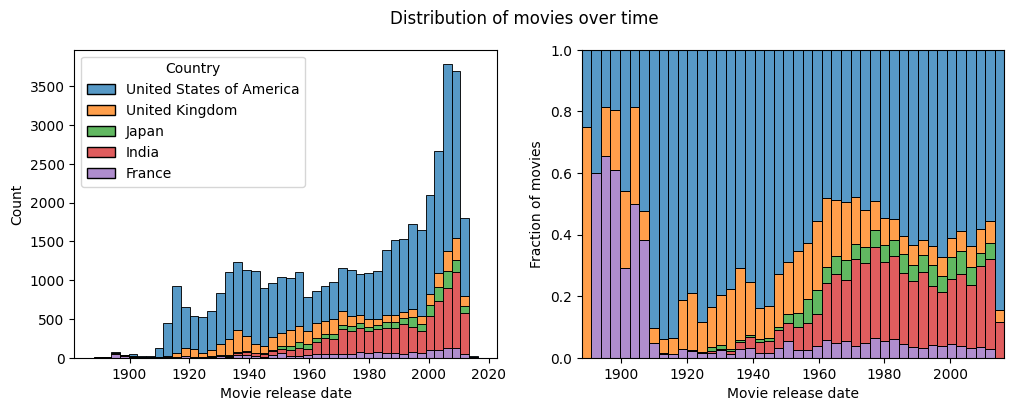

In [17]:
plot.movie_distribution_over_time(movies_parsed)

Based on this visualization we select movies from 1950 to 2013 for our analysis, and see that movies from each country are sufficiently represented.

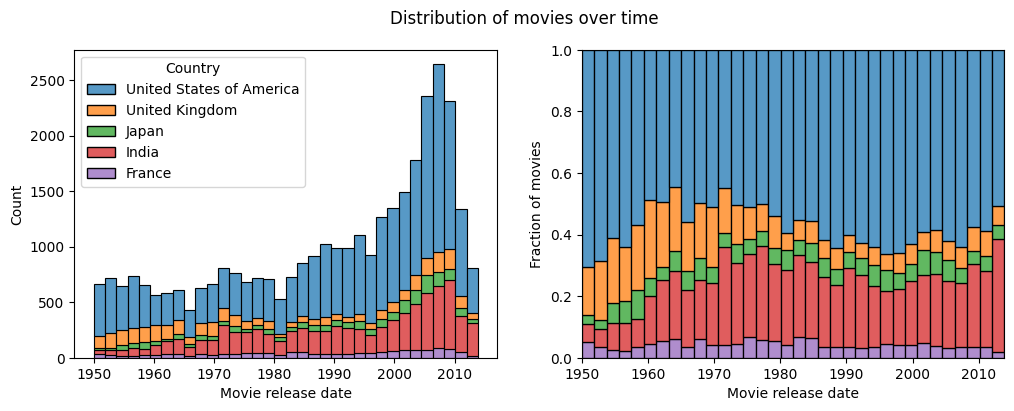

In [18]:
movies = clean.keep_dates(movies_parsed, 1950, 2013)
characters = clean.keep_dates(characters_parsed, 1950, 2013)
plot.movie_distribution_over_time(movies)

Add year and decade columns for convenient grouping.

In [19]:
clean.add_year_and_decade(movies)
clean.add_year_and_decade(characters)
summaries = clean.align_year_and_decade(summaries, characters)
movies[['Movie_Name', 'year', 'decade']].head(5)

,Movie_Name,year,decade
0,Ghosts of Mars,2001,2000
1,Ghosts of Mars,2001,2000
2,Ghosts of Mars,2001,2000
3,Ghosts of Mars,2001,2000
4,Ghosts of Mars,2001,2000


This leaves us with 40% of the original movies and 55% of the original actors.

In [20]:
ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
nsummaries = aggregate.nmovies(summaries)
nactors = aggregate.nactors(characters)
print('Finished filtering dates:')
print(f'- Number of countries:  {ncountries:,} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies:,} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of summaries:  {nsummaries:,} ({nsummaries / nsummaries_raw:.1%})')
print(f'- Number of actors:     {nactors:,} ({nactors / nactors_raw:.1%})')

Finished filtering dates:
- Number of countries:  5 (3.4%)
- Number of movies:     34,008 (41.6%)
- Number of summaries:  20,108 (47.5%)
- Number of actors:     74,133 (54.6%)


The data is cleaned, time to get our hands dirty! (pun intended)

## References

[1] S. Pruitt, “The Lumière Brothers, Pioneers of Cinema,” HISTORY. https://www.history.com/news/the-lumiere-brothers-pioneers-of-cinema (accessed Nov. 17, 2022).

[2] “Global Box Office Down 72%, Digital Leads Home Entertainment in 2020,” Boxoffice, Mar. 26, 2021. https://www.boxofficepro.com/global-box-office-down-72-digital-leads-home-entertainment-in-2020/ (accessed Nov. 16, 2022).